### This file contains the post-processing code for the proposed method with different clustering seeds.

1. `/Reproduction/Analysis-CRS/split_rs-ResultData/` summarises the cumulative gas yield of each clustering seed for each test well in the corresponding `split_rs`. For example, `/Reproduction/Analysis-CRS/0-ResultData/` summarises the cumulative gas yield of each clustering seed for each test well for `split_rs=0`. In these files, `PredCumu` is the forecasting result from the original clustering seed. `Mean` is the forecasting result regarding Proposed-E.

2. `/Reproduction/Analysis-CRS/Metrics-CRS.xlsx` contains the metrics regarding forecasting intervals for each data split. ***The data for Table 5 can be found here.***

3. `/Reproduction/Analysis-CRS/Metrics-CRS/` contains the metrics regarding forecasting intervals for each test well inside each data split.

4. `/Reproduction/Analysis-CRS/ChangCR/Metrics-cluster_rs.xlsx` contains the metrics for each data split under the corresponding clustering seed. For example, `/Reproduction/Analysis-CRS/ChangCR/Metrics-0.xlsx` contains the metrics for each data split for clustering seed 0.

5. `/Reproduction/Analysis-CRS/ChangCR/CRScluster_rs/` contains the metrics for each test well inside each data split under the corresponding clustering seed. For example, `/Reproduction/Analysis-CRS/ChangCR/CRS0/` contains the metrics for each test well inside each data split for clustering seed 0.

6. `/Reproduction/Analysis-CRS/ChangCR/MAPE/`, `/Reproduction/Analysis-CRS/ChangCR/MAE/`, and `/Reproduction/Analysis-CRS/ChangCR/MR/` contains the summary of MAPE, MAE, and MR of the proposed method under different clustering seeds. These files will be used for the statistical inference.

7. The statistical inference results will be printed out during execution. `Passed` means the corresponding null hypothesis is rejected. `Failed` means the corresponding null hypothesis cannot be rejected.

8. `Nemenyi-CRS-MAPE.png`, `Nemenyi-CRS-MAE.png`, `Nemenyi-CRS-MR.png`, and `Nemenyi-CRS.png` will be plotted by this code but were not included in the manuscript or the supplementary file since the majority of the results indicate the null hypothesis of the Friedman test cannot be rejected (i.e. Nemenyi tests are not necessary in the majority of the cases). Moreover, Nemenyi tests in this part also indicates no significant difference.

In [1]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import datetime
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

pd.options.mode.chained_assignment = None

### Raw results and Metrics-CRS file (Section 3.5)

Metrics-CRS stands for the metrics regarding forecasting intervals. i.e. PICP, PINAW, OPICP, and OPINAW.

In [2]:
# Get the current directory.
current_dir = os.getcwd()

# Set up random seeds for data splitting and extra clustering seeds.
split_rs = [290, 150, 266, 78, 148, 133, 155, 135, 178, 241]
new_cluster_rs = [1, 186, 333, 70, 63, 298, 159, 3, 62]

# Set up directories to store result data.
for rs in split_rs:
    os.makedirs(current_dir+'/Analysis-CRS/'+str(rs)+'-ResultData/')
os.makedirs(current_dir+'/Analysis-CRS/Metrics-CRS/')

In [3]:
# This block combines all result data from different clustering seeds and calculates PICP and PINAW.
for rs in split_rs:
    path_rs = current_dir+'/Results/SA/'+str(rs)+'/'+str(rs)+'-ResultData-M200/'
    files_rs = sorted(os.listdir(path_rs))

    picp, pinaw, well_names, lengths = [], [], [], []
    for i in range(len(files_rs)):
        well_names.append(files_rs[i][11:-5])
        df_this_well = pd.read_excel(path_rs+files_rs[i], header = 0, sheet_name = 0)
        df_this_well = df_this_well[df_this_well['Mark']=='forecast'].reset_index(drop=True)
        df_this_well = df_this_well[['TrueCumu', 'PredCumu']]
        lengths.append(len(df_this_well))

        for cluster_rs in new_cluster_rs:
            path_cluster_rs = current_dir+'/Results/CRS/'+str(rs)+'/'+str(rs)+'-'+str(cluster_rs)+'-ResultData/'
            files_cluster_rs = sorted(os.listdir(path_cluster_rs))
            df_this_cluster = pd.read_excel(path_cluster_rs+files_cluster_rs[i], header = 0, sheet_name = 0)
            df_this_cluster = df_this_cluster[df_this_cluster['Mark']=='forecast'].reset_index(drop=True)
            df_this_cluster = df_this_cluster[['PredCumu']]
            df_this_well['PredCumu-'+str(cluster_rs)] = df_this_cluster.values
        
        df_this_well['Upper'] = df_this_well[df_this_well.columns[1:11]].max(axis=1)
        df_this_well['Lower'] = df_this_well[df_this_well.columns[1:11]].min(axis=1)
        df_this_well['Mean'] = df_this_well[df_this_well.columns[1:11]].mean(axis=1)

        picp_this_well, pinaw_this_well = 0, 0
        for j in range(len(df_this_well)):
            if (df_this_well['Upper'][j] >= df_this_well['TrueCumu'][j] >= df_this_well['Lower'][j]):
                picp_this_well += 1
            pinaw_this_well += (df_this_well['Upper'][j]-df_this_well['Lower'][j])
        picp_this_well = picp_this_well/len(df_this_well)
        pinaw_this_well = pinaw_this_well/(len(df_this_well)*(df_this_well['TrueCumu'].max()-df_this_well['TrueCumu'].min()))
        picp.append(picp_this_well)
        pinaw.append(pinaw_this_well)
        
        writer = pd.ExcelWriter(current_dir+'/Analysis-CRS/'+str(rs)+'-ResultData/'+files_rs[i])
        df_this_well.to_excel(writer, float_format='%.5f', header=True, index=False)
        writer.close()
    
    df_eval_this_rs = pd.DataFrame({'Well':well_names, 'Length':lengths, 'PICP':picp, 'PINAW':pinaw})
    writer = pd.ExcelWriter(current_dir+'/Analysis-CRS/Metrics-CRS/Metrics-CRS-'+str(rs)+'.xlsx')
    df_eval_this_rs.to_excel(writer, float_format='%.5f', header=True, index=False)
    writer.close()

# This block calculates OPICP and OPINAW.
opicp, opinaw = [], []

path_rs = current_dir+'/Analysis-CRS/Metrics-CRS/'
files_rs = sorted(os.listdir(path_rs))

for i in range(len(files_rs)):
    df = pd.read_excel(path_rs+files_rs[i], header = 0, sheet_name = 0)

    opicp.append((df['PICP']*df['Length']).sum()/df['Length'].sum())
    opinaw.append((df['PINAW']*df['Length']).sum()/df['Length'].sum())

result = pd.DataFrame({'Split':split_rs, 'OPICP': opicp, 'OPINAW':opinaw})
writer = pd.ExcelWriter(current_dir+'/Analysis-CRS/Metrics-CRS.xlsx')
result.to_excel(writer, float_format='%.5f', header=True, index=False)
writer.close()

#### Figure 14

1. The metrics for example well 1 are read from `/Reproduction/Analysis-CRS/Metrics-CRS/Metrics-CRS-266.xlsx` and `/Reproduction/Analysis-CRS/ChangCR/CRS999/Metrics-266.xlsx` (well 20-P61W1).

1. The metrics for example well 2 are read from `/Reproduction/Analysis-CRS/Metrics-CRS/Metrics-CRS-133.xlsx` and `/Reproduction/Analysis-CRS/ChangCR/CRS999/Metrics-133.xlsx` (well 20-P02W6).

1. The metrics for example well 3 are read from `/Reproduction/Analysis-CRS/Metrics-CRS/Metrics-CRS-266.xlsx` and `/Reproduction/Analysis-CRS/ChangCR/CRS999/Metrics-266.xlsx` (well 33-P51W7).

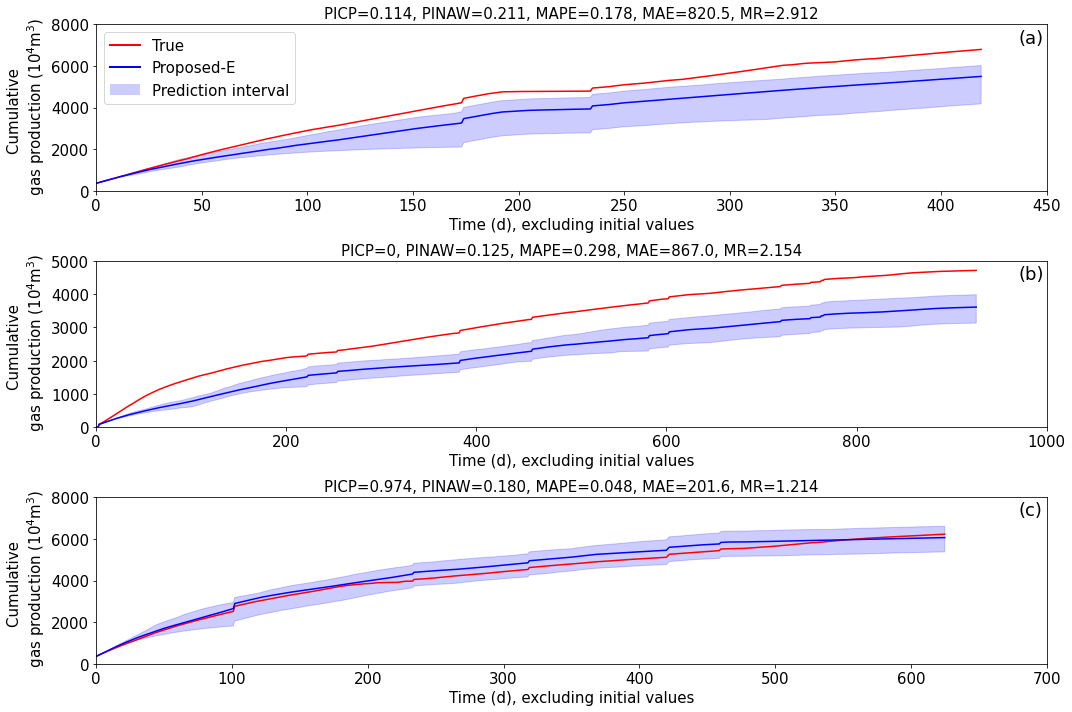

In [4]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10))

for rs in [266]:
    path_rs = current_dir+'/Results/SA/'+str(rs)+'/'+str(rs)+'-ResultData-M200/'
    files_rs = sorted(os.listdir(path_rs))

    for i in range(13,14):
        df_this_well = pd.read_excel(path_rs+files_rs[i], header = 0, sheet_name = 0)
        df_this_well = df_this_well[df_this_well['Mark']=='forecast'].reset_index(drop=True)
        df_this_well = df_this_well[['TrueCumu', 'PredCumu']]

        for cluster_rs in new_cluster_rs:
            path_cluster_rs = current_dir+'/Results/CRS/'+str(rs)+'/'+str(rs)+'-'+str(cluster_rs)+'-ResultData/'
            files_cluster_rs = sorted(os.listdir(path_cluster_rs))
            df_this_cluster = pd.read_excel(path_cluster_rs+files_cluster_rs[i], header = 0, sheet_name = 0)
            df_this_cluster = df_this_cluster[df_this_cluster['Mark']=='forecast'].reset_index(drop=True)
            df_this_cluster = df_this_cluster[['PredCumu']]
            df_this_well['PredCumu-'+str(cluster_rs)] = df_this_cluster.values
        
        df_this_well['Upper'] = df_this_well[df_this_well.columns[1:11]].max(axis=1)
        df_this_well['Lower'] = df_this_well[df_this_well.columns[1:11]].min(axis=1)
        df_this_well['Mean'] = df_this_well[df_this_well.columns[1:11]].mean(axis=1)

        ax1.plot(df_this_well['TrueCumu'], color='red')
        ax1.plot(df_this_well['Mean'], color='blue')
        ax1.fill(np.append(df_this_well.index, df_this_well.index[::-1]), np.append(df_this_well['Lower'], df_this_well['Upper'][::-1]), color='blue', alpha=0.2)
        ax1.set_xlim(0, 450)
        ax1.set_ylim(0, 8000)
        ax1.tick_params(axis='both', which='major', labelsize=15)
        ax1.set_title('PICP=0.114, PINAW=0.211, MAPE=0.178, MAE=820.5, MR=2.912', size=15)
        ax1.set_xlabel('Time (d), excluding initial values', size=15)
        ax1.set_ylabel('Cumulative \n gas production $(10^4$m$^3)$',size=15)

for rs in [133]:
    path_rs = current_dir+'/Results/SA/'+str(rs)+'/'+str(rs)+'-ResultData-M200/'
    files_rs = sorted(os.listdir(path_rs))

    for i in range(13,14):
        df_this_well = pd.read_excel(path_rs+files_rs[i], header = 0, sheet_name = 0)
        df_this_well = df_this_well[df_this_well['Mark']=='forecast'].reset_index(drop=True)
        df_this_well = df_this_well[['TrueCumu', 'PredCumu']]

        for cluster_rs in new_cluster_rs:
            path_cluster_rs = current_dir+'/Results/CRS/'+str(rs)+'/'+str(rs)+'-'+str(cluster_rs)+'-ResultData/'
            files_cluster_rs = sorted(os.listdir(path_cluster_rs))
            df_this_cluster = pd.read_excel(path_cluster_rs+files_cluster_rs[i], header = 0, sheet_name = 0)
            df_this_cluster = df_this_cluster[df_this_cluster['Mark']=='forecast'].reset_index(drop=True)
            df_this_cluster = df_this_cluster[['PredCumu']]
            df_this_well['PredCumu-'+str(cluster_rs)] = df_this_cluster.values
        
        df_this_well['Upper'] = df_this_well[df_this_well.columns[1:11]].max(axis=1)
        df_this_well['Lower'] = df_this_well[df_this_well.columns[1:11]].min(axis=1)
        df_this_well['Mean'] = df_this_well[df_this_well.columns[1:11]].mean(axis=1)

        ax2.plot(df_this_well['TrueCumu'], color='red')
        ax2.plot(df_this_well['Mean'], color='blue')
        ax2.fill(np.append(df_this_well.index, df_this_well.index[::-1]), np.append(df_this_well['Lower'], df_this_well['Upper'][::-1]), color='blue', alpha=0.2)
        ax2.set_xlim(0, 1000)
        ax2.set_ylim(0, 5000)
        ax2.tick_params(axis='both', which='major', labelsize=15)
        ax2.set_title('PICP=0, PINAW=0.125, MAPE=0.298, MAE=867.0, MR=2.154', size=15)
        ax2.set_xlabel('Time (d), excluding initial values', size=15)
        ax2.set_ylabel('Cumulative \n gas production $(10^4$m$^3)$',size=15)

for rs in [266]:
    path_rs = current_dir+'/Results/SA/'+str(rs)+'/'+str(rs)+'-ResultData-M200/'
    files_rs = sorted(os.listdir(path_rs))

    for i in range(27,28):
        df_this_well = pd.read_excel(path_rs+files_rs[i], header = 0, sheet_name = 0)
        df_this_well = df_this_well[df_this_well['Mark']=='forecast'].reset_index(drop=True)
        df_this_well = df_this_well[['TrueCumu', 'PredCumu']]

        for cluster_rs in new_cluster_rs:
            path_cluster_rs = current_dir+'/Results/CRS/'+str(rs)+'/'+str(rs)+'-'+str(cluster_rs)+'-ResultData/'
            files_cluster_rs = sorted(os.listdir(path_cluster_rs))
            df_this_cluster = pd.read_excel(path_cluster_rs+files_cluster_rs[i], header = 0, sheet_name = 0)
            df_this_cluster = df_this_cluster[df_this_cluster['Mark']=='forecast'].reset_index(drop=True)
            df_this_cluster = df_this_cluster[['PredCumu']]
            df_this_well['PredCumu-'+str(cluster_rs)] = df_this_cluster.values
        
        df_this_well['Upper'] = df_this_well[df_this_well.columns[1:11]].max(axis=1)
        df_this_well['Lower'] = df_this_well[df_this_well.columns[1:11]].min(axis=1)
        df_this_well['Mean'] = df_this_well[df_this_well.columns[1:11]].mean(axis=1)

        ax3.plot(df_this_well['TrueCumu'], color='red')
        ax3.plot(df_this_well['Mean'], color='blue')
        ax3.fill(np.append(df_this_well.index, df_this_well.index[::-1]), np.append(df_this_well['Lower'], df_this_well['Upper'][::-1]), color='blue', alpha=0.2)
        ax3.set_xlim(0, 700)
        ax3.set_ylim(0, 8000)
        ax3.tick_params(axis='both', which='major', labelsize=15)
        ax3.set_title('PICP=0.974, PINAW=0.180, MAPE=0.048, MAE=201.6, MR=1.214', size=15)
        ax3.set_xlabel('Time (d), excluding initial values', size=15)
        ax3.set_ylabel('Cumulative \n gas production $(10^4$m$^3)$',size=15)

def get_axis_limits(ax, scale_x=0.97, scale_y=0.89):
    return ax.get_xlim()[1]*scale_x, ax.get_ylim()[1]*scale_y

ax1.annotate('(a)', xy=get_axis_limits(ax1), fontsize=18)
ax2.annotate('(b)', xy=get_axis_limits(ax2), fontsize=18)
ax3.annotate('(c)', xy=get_axis_limits(ax3), fontsize=18)
legend_elements = [Line2D([0], [0], color='red', lw=2, label='True'),
                    Line2D([0], [0], color='blue', lw=2, label='Proposed-E'),
                    Patch(facecolor='blue', alpha=0.2, label='Prediction interval')]
ax1.legend(handles=legend_elements, fontsize=15)
plt.tight_layout()
plt.savefig(current_dir+'/Figures/Figure_14.png')

### Metrics file (Also Section 3.5)
The following blocks conduct sensitivity analysis on clustering seed and plot the result.

In [5]:
# 0 is the original clustering seed. 999 is the code for Proposed-E. Other numbers are from `new_cluster_rs`.
all_crs = [0, 1, 186, 333, 70, 63, 298, 159, 3, 62, 999]

for crs in all_crs:
    os.makedirs(current_dir+'/Analysis-CRS/ChangCR/CRS'+str(crs))

In [6]:
for this_crs in all_crs:

    omape_proposed_this_crs, omape_proposednc_this_crs, omape_ann_this_crs, omape_arimar_this_crs, omape_arimap_this_crs, omape_naive_this_crs = [], [], [], [], [], []
    omae_proposed_this_crs, omae_proposednc_this_crs, omae_ann_this_crs, omae_arimar_this_crs, omae_arimap_this_crs, omae_naive_this_crs = [], [], [], [], [], []
    omr_proposed_this_crs, omr_proposednc_this_crs, omr_ann_this_crs, omr_arimar_this_crs, omr_arimap_this_crs, omr_naive_this_crs = [], [], [], [], [], []

    for rs in split_rs:

        print('this_crs=', this_crs, 'Calculating seed', rs, 'at', datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

        path_result_proposed = current_dir+'/Analysis-CRS/'+str(rs)+'-ResultData/'
        files_result_proposed = sorted(os.listdir(path_result_proposed))

        path_result_proposednc = current_dir+'/Results/ProposedNC/'+str(rs)+'-ResultData/'
        files_result_proposednc = sorted(os.listdir(path_result_proposednc))

        path_result_ann = current_dir+'/Results/ANN/'+str(rs)+'-ResultData/'
        files_result_ann = sorted(os.listdir(path_result_ann))

        path_result_arimar = current_dir+'/Results/ARIMAR/'+str(rs)+'-ResultData/'
        files_result_arimar = sorted(os.listdir(path_result_arimar))

        path_result_arimap = current_dir+'/Results/ARIMAP/'+str(rs)+'-ResultData/'
        files_result_arimap = sorted(os.listdir(path_result_arimap))

        path_result_naive = current_dir+'/Results/Naive/'+str(rs)+'-ResultData/'
        files_result_naive = sorted(os.listdir(path_result_naive))

        mape_proposed_this_rs, mape_proposednc_this_rs, mape_ann_this_rs, mape_arimar_this_rs, mape_arimap_this_rs, mape_naive_this_rs = [], [], [], [], [], []
        mae_proposed_this_rs, mae_proposednc_this_rs, mae_ann_this_rs, mae_arimar_this_rs, mae_arimap_this_rs, mae_naive_this_rs = [], [], [], [], [], []
        rank_proposed_this_rs, rank_proposednc_this_rs, rank_ann_this_rs, rank_arimar_this_rs, rank_arimap_this_rs, rank_naive_this_rs = [], [], [], [], [], []
        lengths_this_rs = []
        wells_this_rs = []

        for i in range(len(files_result_proposed)):
            ## 'Mark'=='forecast' rows have already been removed when producing CRS results.
            # The original proposed method.
            if this_crs == 0:
                df_proposed = pd.read_excel(path_result_proposed+files_result_proposed[i], header = 0, sheet_name = 0)
                col_proposed = df_proposed['PredCumu']

            # Proposed-E.
            elif this_crs == 999:
                df_proposed = pd.read_excel(path_result_proposed+files_result_proposed[i], header = 0, sheet_name = 0)
                col_proposed = df_proposed['Mean']
            
            # Proposed method with different CRS.
            else:
                df_proposed = pd.read_excel(path_result_proposed+files_result_proposed[i], header = 0, sheet_name = 0)
                col_proposed = df_proposed['PredCumu-'+str(this_crs)]
                    
            col_true = df_proposed['TrueCumu']
            lengths_this_rs.append(len(col_true))
            wells_this_rs.append(files_result_proposed[i][11:-5])

            df_proposednc = pd.read_excel(path_result_proposednc+files_result_proposednc[i], header = 0, sheet_name = 0)
            df_proposednc = df_proposednc[df_proposednc['Mark'] == 'forecast'].reset_index(drop=True)
            col_proposednc = df_proposednc['PredCumu']

            df_ann = pd.read_excel(path_result_ann+files_result_ann[i], header = 0, sheet_name = 0)
            df_ann = df_ann[df_ann['Mark'] == 'forecast'].reset_index(drop=True)
            col_ann = df_ann['PredCumu']

            df_arimar = pd.read_excel(path_result_arimar+files_result_arimar[i], header = 0, sheet_name = 0)
            df_arimar = df_arimar[df_arimar['Mark'] == 'forecast'].reset_index(drop=True)
            col_arimar = df_arimar['PredCumu']

            df_arimap = pd.read_excel(path_result_arimap+files_result_arimap[i], header = 0, sheet_name = 0)
            df_arimap = df_arimap[df_arimap['Mark'] == 'forecast'].reset_index(drop=True)
            col_arimap = df_arimap['PredCumu']

            df_naive = pd.read_excel(path_result_naive+files_result_naive[i], header = 0, sheet_name = 0)
            df_naive = df_naive[df_naive['Mark'] == 'forecast'].reset_index(drop=True)
            col_naive = df_naive['PredCumu']

            ape_proposed_this_well = abs(col_proposed-col_true)/col_true
            ape_proposednc_this_well = abs(col_proposednc-col_true)/col_true
            ape_ann_this_well = abs(col_ann-col_true)/col_true
            ape_arimar_this_well = abs(col_arimar-col_true)/col_true
            ape_arimap_this_well = abs(col_arimap-col_true)/col_true
            ape_naive_this_well = abs(col_naive-col_true)/col_true

            mape_proposed_this_rs.append(np.mean(ape_proposed_this_well))
            mape_proposednc_this_rs.append(np.mean(ape_proposednc_this_well))
            mape_ann_this_rs.append(np.mean(ape_ann_this_well))
            mape_arimar_this_rs.append(np.mean(ape_arimar_this_well))
            mape_arimap_this_rs.append(np.mean(ape_arimap_this_well))
            mape_naive_this_rs.append(np.mean(ape_naive_this_well))

            ae_proposed_this_well = abs(col_proposed-col_true)
            ae_proposednc_this_well = abs(col_proposednc-col_true)
            ae_ann_this_well = abs(col_ann-col_true)
            ae_arimar_this_well = abs(col_arimar-col_true)
            ae_arimap_this_well = abs(col_arimap-col_true)
            ae_naive_this_well = abs(col_naive-col_true)

            mae_proposed_this_rs.append(np.mean(ae_proposed_this_well))
            mae_proposednc_this_rs.append(np.mean(ae_proposednc_this_well))
            mae_ann_this_rs.append(np.mean(ae_ann_this_well))
            mae_arimar_this_rs.append(np.mean(ae_arimar_this_well))
            mae_arimap_this_rs.append(np.mean(ae_arimap_this_well))
            mae_naive_this_rs.append(np.mean(ae_naive_this_well))

            all_errors_this_well = pd.DataFrame({'Proposed':ape_proposed_this_well, 'ProposedNC':ape_proposednc_this_well, 'ANN':ape_ann_this_well, 
                                                 'ARIMAR':ape_arimar_this_well, 'ARIMAP':ape_arimap_this_well, 'Naive':ape_naive_this_well})
            rank_this_well = np.argsort(all_errors_this_well)

            rank_proposed_this_well, rank_proposednc_this_well, rank_ann_this_well, rank_arimar_this_well, rank_arimap_this_well, rank_naive_this_well = [], [], [], [], [], []

            for j in range(len(rank_this_well)):
                row = rank_this_well.iloc[j].reset_index(drop=True)

                rank_proposed_this_well.append(row[row==0].index[0]+1)
                rank_proposednc_this_well.append(row[row==1].index[0]+1)
                rank_ann_this_well.append(row[row==2].index[0]+1)
                rank_arimar_this_well.append(row[row==3].index[0]+1)
                rank_arimap_this_well.append(row[row==4].index[0]+1)
                rank_naive_this_well.append(row[row==5].index[0]+1)

            rank_proposed_this_rs.append(np.mean(rank_proposed_this_well))
            rank_proposednc_this_rs.append(np.mean(rank_proposednc_this_well))
            rank_ann_this_rs.append(np.mean(rank_ann_this_well))
            rank_arimar_this_rs.append(np.mean(rank_arimar_this_well))
            rank_arimap_this_rs.append(np.mean(rank_arimap_this_well))
            rank_naive_this_rs.append(np.mean(rank_naive_this_well))

        result_this_rs = pd.DataFrame({'Proposed_mape':mape_proposed_this_rs, 'ProposedNC_mape':mape_proposednc_this_rs, 'ANN_mape':mape_ann_this_rs, 
                                       'ARIMAR_mape':mape_arimar_this_rs, 'ARIMAP_mape':mape_arimap_this_rs, 'Naive_mape':mape_naive_this_rs,
                                       'Proposed_mae':mae_proposed_this_rs, 'ProposedNC_mae':mae_proposednc_this_rs, 'ANN_mae':mae_ann_this_rs, 
                                       'ARIMAR_mae':mae_arimar_this_rs, 'ARIMAP_mae':mae_arimap_this_rs, 'Naive_mae':mae_naive_this_rs,
                                       'Proposed_mr':rank_proposed_this_rs, 'ProposedNC_mr':rank_proposednc_this_rs, 'ANN_mr':rank_ann_this_rs, 
                                       'ARIMAR_mr':rank_arimar_this_rs, 'ARIMAP_mr':rank_arimap_this_rs, 'Naive_mr':rank_naive_this_rs,
                                       'Length':lengths_this_rs, 'Well':wells_this_rs})
        writer = pd.ExcelWriter(current_dir+'/Analysis-CRS/ChangCR/CRS'+str(this_crs)+'/'+'Metrics-'+str(rs)+'.xlsx')
        result_this_rs.to_excel(writer, float_format='%.5f', header=True, index=False)
        writer.close()

        omape_proposed_this_rs = np.sum(result_this_rs['Proposed_mape']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        omae_proposed_this_rs = np.sum(result_this_rs['Proposed_mae']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        omr_proposed_this_rs = np.sum(result_this_rs['Proposed_mr']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])

        omape_proposednc_this_rs = np.sum(result_this_rs['ProposedNC_mape']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        omae_proposednc_this_rs = np.sum(result_this_rs['ProposedNC_mae']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        omr_proposednc_this_rs = np.sum(result_this_rs['ProposedNC_mr']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])

        omape_ann_this_rs = np.sum(result_this_rs['ANN_mape']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        omae_ann_this_rs = np.sum(result_this_rs['ANN_mae']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        omr_ann_this_rs = np.sum(result_this_rs['ANN_mr']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        
        omape_arimar_this_rs = np.sum(result_this_rs['ARIMAR_mape']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        omae_arimar_this_rs = np.sum(result_this_rs['ARIMAR_mae']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        omr_arimar_this_rs = np.sum(result_this_rs['ARIMAR_mr']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])

        omape_arimap_this_rs = np.sum(result_this_rs['ARIMAP_mape']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        omae_arimap_this_rs = np.sum(result_this_rs['ARIMAP_mae']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        omr_arimap_this_rs = np.sum(result_this_rs['ARIMAP_mr']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])

        omape_naive_this_rs = np.sum(result_this_rs['Naive_mape']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        omae_naive_this_rs = np.sum(result_this_rs['Naive_mae']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        omr_naive_this_rs = np.sum(result_this_rs['Naive_mr']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        
        omape_proposed_this_crs.append(omape_proposed_this_rs)
        omape_proposednc_this_crs.append(omape_proposednc_this_rs)
        omape_ann_this_crs.append(omape_ann_this_rs)
        omape_arimar_this_crs.append(omape_arimar_this_rs)
        omape_arimap_this_crs.append(omape_arimap_this_rs)
        omape_naive_this_crs .append(omape_naive_this_rs)

        omae_proposed_this_crs.append(omae_proposed_this_rs)
        omae_proposednc_this_crs.append(omae_proposednc_this_rs)
        omae_ann_this_crs.append(omae_ann_this_rs)
        omae_arimar_this_crs.append(omae_arimar_this_rs)
        omae_arimap_this_crs.append(omae_arimap_this_rs)
        omae_naive_this_crs .append(omae_naive_this_rs)

        omr_proposed_this_crs.append(omr_proposed_this_rs)
        omr_proposednc_this_crs.append(omr_proposednc_this_rs)
        omr_ann_this_crs.append(omr_ann_this_rs)
        omr_arimar_this_crs.append(omr_arimar_this_rs)
        omr_arimap_this_crs.append(omr_arimap_this_rs)
        omr_naive_this_crs .append(omr_naive_this_rs)

    result_this_crs = pd.DataFrame({'rs':split_rs,
                                    'Proposed_omape':omape_proposed_this_crs, 'ProposedNC_omape':omape_proposednc_this_crs, 'ANN_omape':omape_ann_this_crs,
                                    'ARIMAR_omape':omape_arimar_this_crs, 'ARIMAP_omape':omape_arimap_this_crs, 'Naive_omape':omape_naive_this_crs,
                                    'Proposed_omae':omae_proposed_this_crs, 'ProposedNC_omae':omae_proposednc_this_crs, 'ANN_omae':omae_ann_this_crs, 
                                    'ARIMAR_omae':omae_arimar_this_crs, 'ARIMAP_omae':omae_arimap_this_crs, 'Naive_omae':omae_naive_this_crs,
                                    'Proposed_omr':omr_proposed_this_crs, 'ProposedNC_omr':omr_proposednc_this_crs, 'ANN_omr':omr_ann_this_crs, 
                                    'ARIMAR_omr':omr_arimar_this_crs, 'ARIMAP_omr':omr_arimap_this_crs, 'Naive_omr':omr_naive_this_crs})
    writer = pd.ExcelWriter(current_dir+'/Analysis-CRS/ChangCR/Metrics-'+str(this_crs)+'.xlsx')
    result_this_crs.to_excel(writer, float_format='%.5f', header=True, index=False)
    writer.close()

this_crs= 0 Calculating seed 290 at 2024-08-16 15:34:41
this_crs= 0 Calculating seed 150 at 2024-08-16 15:34:51
this_crs= 0 Calculating seed 266 at 2024-08-16 15:35:02
this_crs= 0 Calculating seed 78 at 2024-08-16 15:35:15
this_crs= 0 Calculating seed 148 at 2024-08-16 15:35:28
this_crs= 0 Calculating seed 133 at 2024-08-16 15:35:44
this_crs= 0 Calculating seed 155 at 2024-08-16 15:36:00
this_crs= 0 Calculating seed 135 at 2024-08-16 15:36:17
this_crs= 0 Calculating seed 178 at 2024-08-16 15:36:35
this_crs= 0 Calculating seed 241 at 2024-08-16 15:36:57
this_crs= 1 Calculating seed 290 at 2024-08-16 15:37:27
this_crs= 1 Calculating seed 150 at 2024-08-16 15:37:36
this_crs= 1 Calculating seed 266 at 2024-08-16 15:37:47
this_crs= 1 Calculating seed 78 at 2024-08-16 15:37:59
this_crs= 1 Calculating seed 148 at 2024-08-16 15:38:12
this_crs= 1 Calculating seed 133 at 2024-08-16 15:38:27
this_crs= 1 Calculating seed 155 at 2024-08-16 15:38:43
this_crs= 1 Calculating seed 135 at 2024-08-16 15:

#### Figure 13

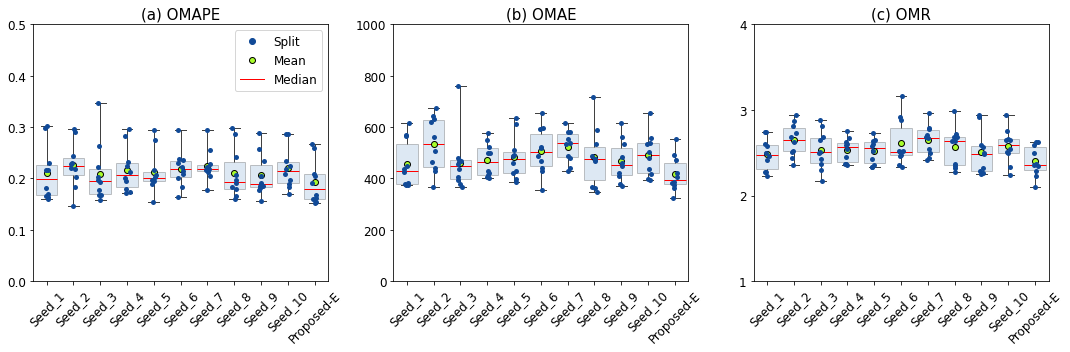

In [7]:
df1 = pd.DataFrame()

for i in range(len(all_crs)):
    
    this_crs = all_crs[i]
    df = pd.read_excel(current_dir+'/Analysis-CRS/ChangCR/Metrics-'+str(this_crs)+'.xlsx', header = 0, sheet_name = 0)

    if this_crs == 999:
        df1['Proposed-E'] = df['Proposed_omape']
    else:
        df1['Seed_'+str(i+1)] = df['Proposed_omape']

df2 = pd.DataFrame()

for i in range(len(all_crs)):
    
    this_crs = all_crs[i]
    df = pd.read_excel(current_dir+'/Analysis-CRS/ChangCR/Metrics-'+str(this_crs)+'.xlsx', header = 0, sheet_name = 0)

    if this_crs == 999:
        df2['Proposed-E'] = df['Proposed_omae']
    else:
        df2['Seed_'+str(i+1)] = df['Proposed_omae']

df3 = pd.DataFrame()

for i in range(len(all_crs)):
    
    this_crs = all_crs[i]
    df = pd.read_excel(current_dir+'/Analysis-CRS/ChangCR/Metrics-'+str(this_crs)+'.xlsx', header = 0, sheet_name = 0)

    if this_crs == 999:
        df3['Proposed-E'] = df['Proposed_omr']
    else:
        df3['Seed_'+str(i+1)] = df['Proposed_omr']

f, axes = plt.subplots(1, 3, figsize=(15, 5))
ax1, ax2, ax3 = axes[0], axes[1], axes[2]
axes_list = [ax1, ax2, ax3]
ax1 = sns.boxplot(data=df1, ax=ax1, boxprops=dict(alpha=.3, facecolor='#8FB5DA'), whis=(0,100), medianprops=dict(color='red'), showmeans=True, meanprops=dict(marker='o', markerfacecolor='#A9FD2B', markeredgecolor='black'))
ax2 = sns.boxplot(data=df2, ax=ax2, boxprops=dict(alpha=.3, facecolor='#8FB5DA'), whis=(0,100), medianprops=dict(color='red'), showmeans=True, meanprops=dict(marker='o', markerfacecolor='#A9FD2B', markeredgecolor='black'))
ax3 = sns.boxplot(data=df3, ax=ax3, boxprops=dict(alpha=.3, facecolor='#8FB5DA'), whis=(0,100), medianprops=dict(color='red'), showmeans=True, meanprops=dict(marker='o', markerfacecolor='#A9FD2B', markeredgecolor='black'))
sns.stripplot(data=df1, ax=ax1, color='#114A97')
sns.stripplot(data=df2, ax=ax2, color='#114A97')
sns.stripplot(data=df3, ax=ax3, color='#114A97')
ax1.set_title('(a) OMAPE', size=15)
ax2.set_title('(b) OMAE', size=15) 
ax3.set_title('(c) OMR', size=15)
ax1.set_yticks(np.linspace(0, 0.5, 6))
ax2.set_yticks(np.linspace(0, 1000, 6))
ax3.set_yticks(np.linspace(1, 4, 4))
for ax in axes_list:
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='both', which='major', labelsize=12)

legend_elements = [Line2D([], [], color='#114A97', marker='o', linestyle='', label='Split'),
                   Line2D([], [], color='#A9FD2B', marker='o', markeredgecolor='black', linestyle='', label='Mean'),
                   Line2D([0], [0], color='red', lw=1, label='Median')]
ax1.legend(handles=legend_elements, fontsize=12)

plt.tight_layout()
plt.savefig(current_dir+'/Figures/Figure_13.png')

### Statistical inference (Section 3.6.3)
The following blocks conduct Friedman-Nemenyi tests for the results above.

In [8]:
os.makedirs(current_dir+'/Analysis-CRS/ChangCR/MAPE/')
os.makedirs(current_dir+'/Analysis-CRS/ChangCR/MAE/')
os.makedirs(current_dir+'/Analysis-CRS/ChangCR/MR/')

In [9]:
# This block summarises the MAPE, MAE, and MR of the proposed method under different clustering seeds.
for rs in split_rs:

    df_mape, df_mae, df_mr = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

    for i in range(len(all_crs)):
        this_crs = all_crs[i]
        df = pd.read_excel(current_dir+'/Analysis-CRS/ChangCR/CRS'+str(this_crs)+'/Metrics-'+str(rs)+'.xlsx', header = 0, sheet_name = 0)
        df_mape['Well'] = df['Well']
        df_mae['Well'] = df['Well']
        df_mr['Well'] = df['Well']
        df_mape['Seed_'+str(i+1)] = df['Proposed_mape']
        df_mae['Seed_'+str(i+1)] = df['Proposed_mae']
        df_mr['Seed_'+str(i+1)] = df['Proposed_mr']
    
    df_mape.columns = ['Well', 'MAPE_0', 'MAPE_1', 'MAPE_2', 'MAPE_3', 'MAPE_4', 'MAPE_5' ,'MAPE_6' ,'MAPE_7', 'MAPE_8', 'MAPE_9', 'MAPE_E']
    df_mae.columns = ['Well', 'MAE_0', 'MAE_1', 'MAE_2', 'MAE_3', 'MAE_4', 'MAE_5' ,'MAE_6' ,'MAE_7', 'MAE_8', 'MAE_9', 'MAE_E']
    df_mr.columns = ['Well', 'MR_0', 'MR_1', 'MR_2', 'MR_3', 'MR_4', 'MR_5' ,'MR_6' ,'MR_7', 'MR_8', 'MR_9', 'MR_E']

    writer = pd.ExcelWriter(current_dir+'/Analysis-CRS/ChangCR/MAPE/MAPE-'+str(rs)+'.xlsx')
    df_mape.to_excel(writer, float_format='%.5f', header=True, index=False)
    writer.close()

    writer = pd.ExcelWriter(current_dir+'/Analysis-CRS/ChangCR/MAE/MAE-'+str(rs)+'.xlsx')
    df_mae.to_excel(writer, float_format='%.5f', header=True, index=False)
    writer.close()

    writer = pd.ExcelWriter(current_dir+'/Analysis-CRS/ChangCR/MR/MR-'+str(rs)+'.xlsx')
    df_mr.to_excel(writer, float_format='%.5f', header=True, index=False)
    writer.close()

#### Split-wise tests. Friedman test results are printed out as numbers (p-values) and texts (passed or failed). Nemenyi test results are printed out as figures.

0.6442996727165899 290 MAPE Failed
0.4471050094566835 150 MAPE Failed
0.6803458512388019 266 MAPE Failed
0.9605566161567548 78 MAPE Failed
0.3275798712690918 148 MAPE Failed
0.4321009573544019 133 MAPE Failed
0.10941125868706314 155 MAPE Failed
0.0299549500618929 135 ===MAPE Passed===
0.8676066076876124 178 MAPE Failed
0.6906595029390559 241 MAPE Failed
0.5895806896379108 290 MAE Failed
0.2649437570635691 150 MAE Failed
0.6323311312773886 266 MAE Failed
0.9907722834706668 78 MAE Failed
0.1810658600858677 148 MAE Failed
0.24303739350199824 133 MAE Failed
0.08603331586019747 155 MAE Failed
0.07032870861268692 135 MAE Failed
0.984680337507086 178 MAE Failed
0.7046746666860297 241 MAE Failed
0.8527683151817859 290 MR Failed
0.23545989308052914 150 MR Failed
0.29469567684799225 266 MR Failed
0.8732116384235619 78 MR Failed
0.32188725476656077 148 MR Failed
0.4623638033955848 133 MR Failed
0.09048146362393597 155 MR Failed
0.02724415827764961 135 ===MR Passed===
0.6226806806808852 178 MR Fai

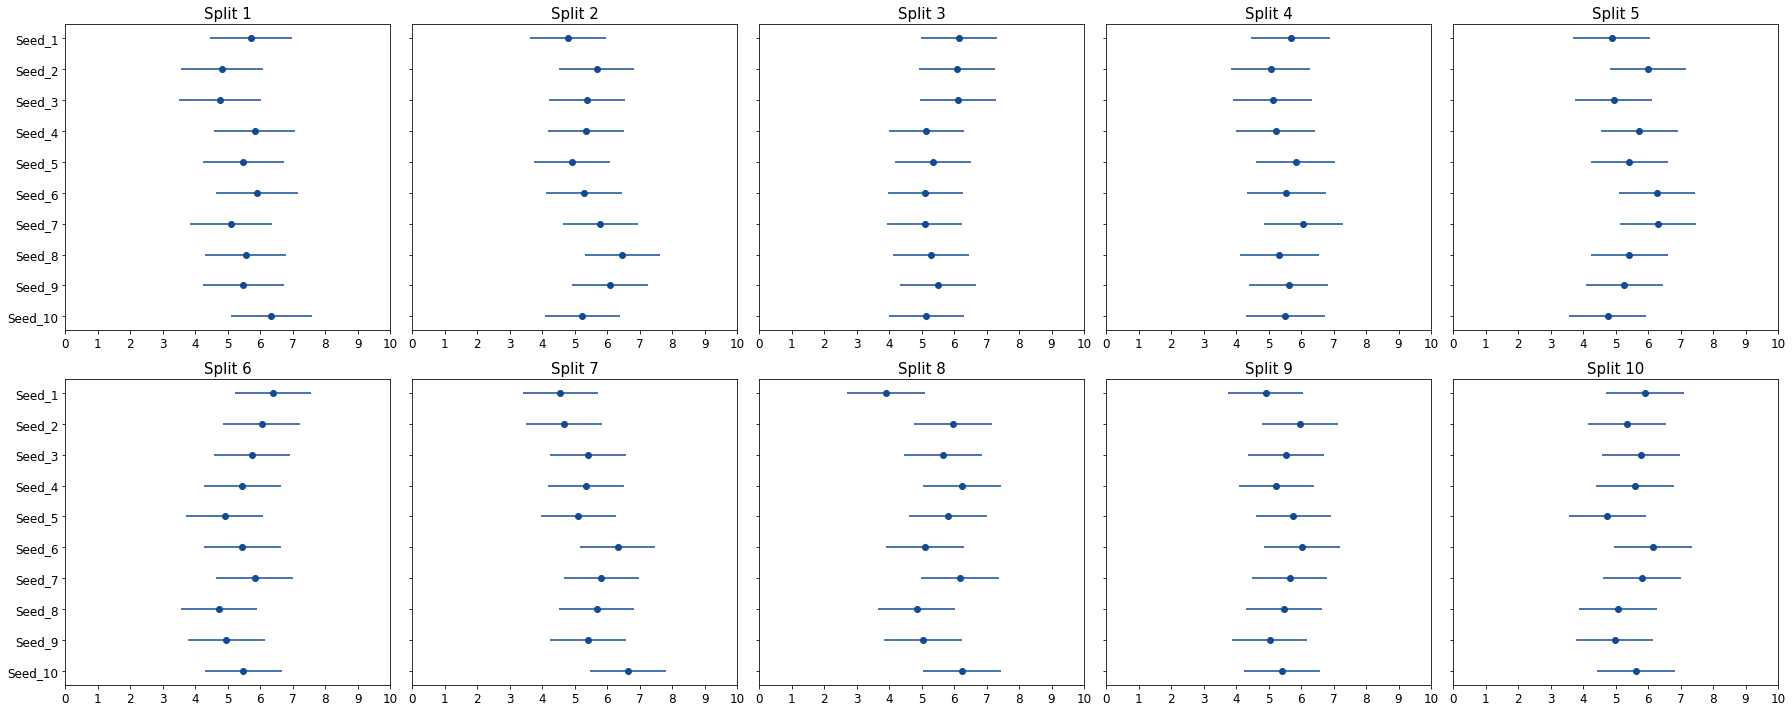

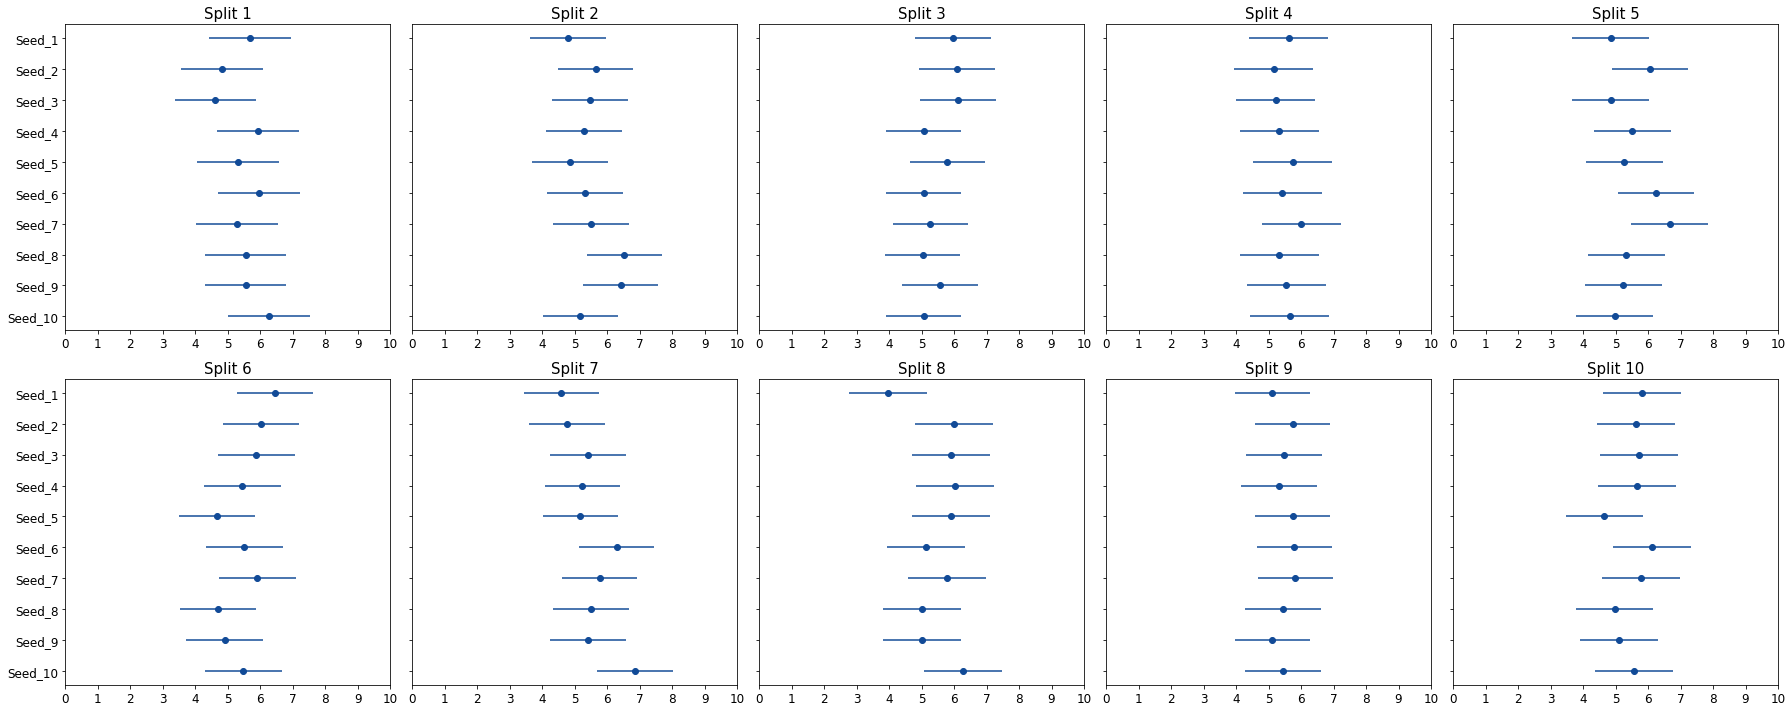

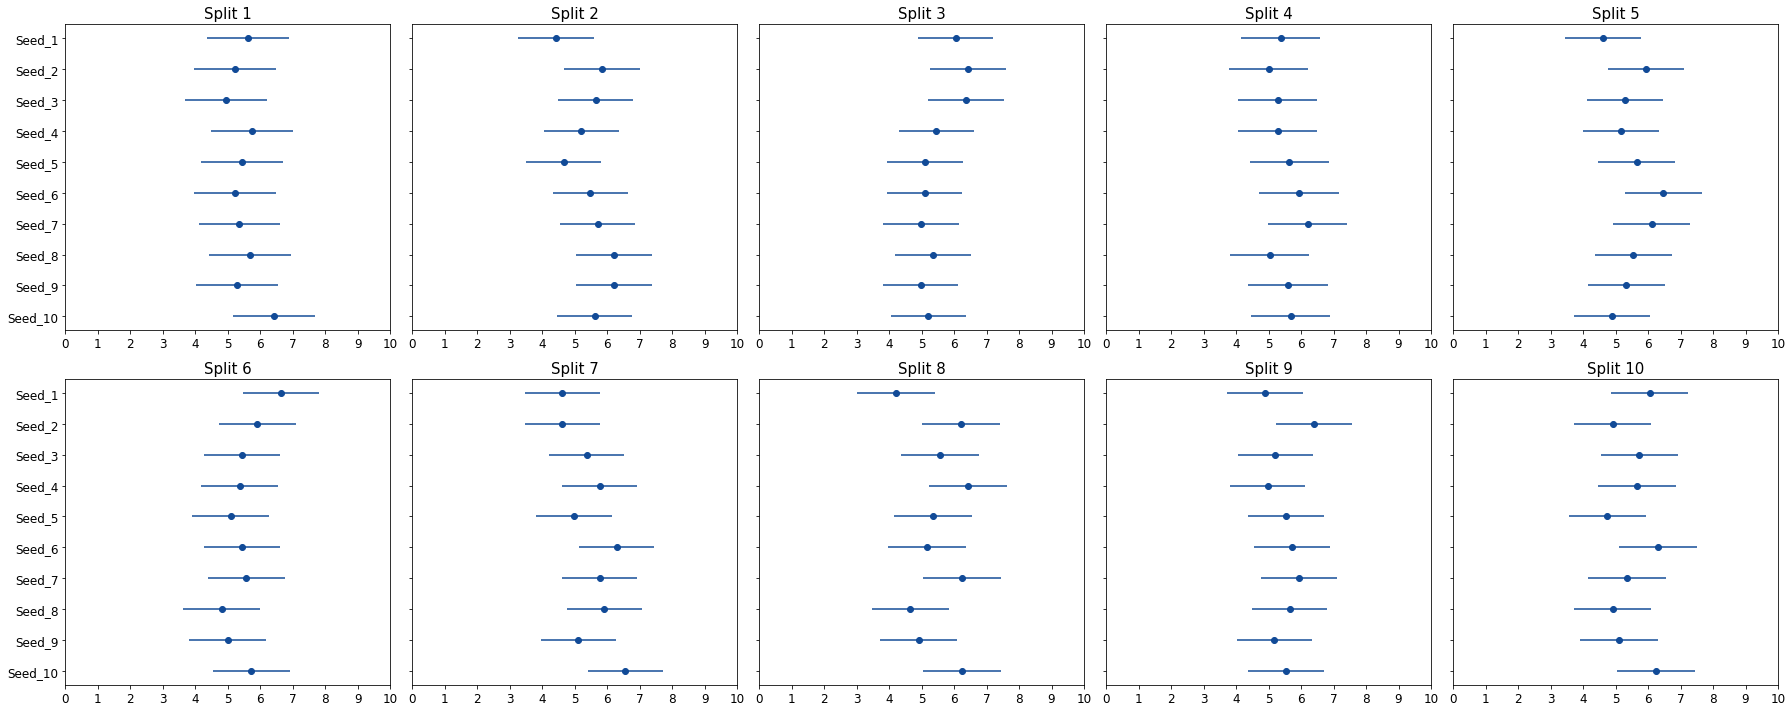

In [10]:
def nemenyi_value(n_models, n_datasets, q):
    return q * (np.sqrt(n_models*(n_models+1) / (6*n_datasets)))

n_models = 10
q_alpha = 3.164

# MAPE
f, axes = plt.subplots(2, 5, figsize=(25, 10))
ax1, ax2, ax3, ax4, ax5 = axes[0,0], axes[0,1], axes[0,2], axes[0,3], axes[0,4]
ax6, ax7, ax8, ax9, ax10 = axes[1,0], axes[1,1], axes[1,2], axes[1,3], axes[1,4]
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]

counter = 0
for rs in split_rs:
    
    df = pd.read_excel(current_dir+'/Analysis-CRS/ChangCR/MAPE/MAPE-'+str(rs)+'.xlsx', header = 0, sheet_name = 0)
    df = df[['MAPE_0', 'MAPE_1', 'MAPE_2', 'MAPE_3', 'MAPE_4', 'MAPE_5' ,'MAPE_6' ,'MAPE_7', 'MAPE_8', 'MAPE_9']]
    
    rank = pd.DataFrame(np.nan, index=list(df.index), columns=df.columns)
    for j in range(len(df)):
        rank.iloc[j,:] = scipy.stats.rankdata(df.iloc[j,:], method='average')

    pvalue = scipy.stats.friedmanchisquare(df['MAPE_0'], df['MAPE_1'], df['MAPE_2'], df['MAPE_3'], df['MAPE_4'], df['MAPE_5'], df['MAPE_6'], df['MAPE_7'], df['MAPE_8'], df['MAPE_9']).pvalue
    
    if pvalue <= 0.05:
        print(pvalue, rs, '===MAPE Passed===')
    else:
        print(pvalue, rs, 'MAPE Failed')
    
    CD = nemenyi_value(n_models, len(rank), q_alpha)
    rank_mean = list(rank.mean())
    interval_min = [x for x in rank_mean-CD/2]
    interval_max = [x for x in rank_mean+CD/2]

    rank.columns = ['Seed_1', 'Seed_2', 'Seed_3', 'Seed_4', 'Seed_5', 'Seed_6', 'Seed_7', 'Seed_8', 'Seed_9', 'Seed_10']
    axes_list[counter].scatter(rank_mean, rank.columns, color='#114A97')
    axes_list[counter].hlines(rank.columns, interval_min, interval_max, color='#114A97')
    axes_list[counter].set_xlim(0,10)
    axes_list[counter].set_xticks(np.linspace(0,10,11))
    axes_list[counter].set_ylim(axes_list[counter].get_ylim()[::-1])
    axes_list[counter].tick_params(axis='both', which='major', labelsize=12)
    axes_list[counter].set_title('Split '+str(counter+1), size=15)
    if (counter != 0) and (counter != 5):
        axes_list[counter].set_yticklabels('')
    counter += 1

plt.tight_layout()
plt.savefig(current_dir+'/Figures/Nemenyi-CRS-MAPE.png')

# MAE
f, axes = plt.subplots(2, 5, figsize=(25, 10))
ax1, ax2, ax3, ax4, ax5 = axes[0,0], axes[0,1], axes[0,2], axes[0,3], axes[0,4]
ax6, ax7, ax8, ax9, ax10 = axes[1,0], axes[1,1], axes[1,2], axes[1,3], axes[1,4]
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]

counter = 0
for rs in split_rs:
    
    df = pd.read_excel(current_dir+'/Analysis-CRS/ChangCR/MAE/MAE-'+str(rs)+'.xlsx', header = 0, sheet_name = 0)
    df = df[['MAE_0', 'MAE_1', 'MAE_2', 'MAE_3', 'MAE_4', 'MAE_5' ,'MAE_6' ,'MAE_7', 'MAE_8', 'MAE_9']]

    rank = pd.DataFrame(np.nan, index=list(df.index), columns=df.columns)
    for j in range(len(df)):
        rank.iloc[j,:] = scipy.stats.rankdata(df.iloc[j,:], method='average')

    pvalue = scipy.stats.friedmanchisquare(df['MAE_0'], df['MAE_1'], df['MAE_2'], df['MAE_3'], df['MAE_4'], df['MAE_5'], df['MAE_6'], df['MAE_7'], df['MAE_8'], df['MAE_9']).pvalue
    
    if pvalue <= 0.05:
        print(pvalue, rs, '===MAE Passed===')
    else:
        print(pvalue, rs, 'MAE Failed')
    
    CD = nemenyi_value(n_models, len(rank), q_alpha)
    rank_mean = list(rank.mean())
    interval_min = [x for x in rank_mean-CD/2]
    interval_max = [x for x in rank_mean+CD/2]

    rank.columns = ['Seed_1', 'Seed_2', 'Seed_3', 'Seed_4', 'Seed_5', 'Seed_6', 'Seed_7', 'Seed_8', 'Seed_9', 'Seed_10']
    axes_list[counter].scatter(rank_mean, rank.columns, color='#114A97')
    axes_list[counter].hlines(rank.columns, interval_min, interval_max, color='#114A97')
    axes_list[counter].set_xlim(0,10)
    axes_list[counter].set_xticks(np.linspace(0,10,11))
    axes_list[counter].set_ylim(axes_list[counter].get_ylim()[::-1])
    axes_list[counter].tick_params(axis='both', which='major', labelsize=12)
    axes_list[counter].set_title('Split '+str(counter+1), size=15)
    if (counter != 0) and (counter != 5):
        axes_list[counter].set_yticklabels('')
    counter += 1

plt.tight_layout()
plt.savefig(current_dir+'/Figures/Nemenyi-CRS-MAE.png')

# MR
f, axes = plt.subplots(2, 5, figsize=(25, 10))
ax1, ax2, ax3, ax4, ax5 = axes[0,0], axes[0,1], axes[0,2], axes[0,3], axes[0,4]
ax6, ax7, ax8, ax9, ax10 = axes[1,0], axes[1,1], axes[1,2], axes[1,3], axes[1,4]
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]

counter = 0
for rs in split_rs:
    
    df = pd.read_excel(current_dir+'/Analysis-CRS/ChangCR/MR/MR-'+str(rs)+'.xlsx', header = 0, sheet_name = 0)
    df = df[['MR_0', 'MR_1', 'MR_2', 'MR_3', 'MR_4', 'MR_5' ,'MR_6' ,'MR_7', 'MR_8', 'MR_9']]

    rank = pd.DataFrame(np.nan, index=list(df.index), columns=df.columns)
    for j in range(len(df)):
        rank.iloc[j,:] = scipy.stats.rankdata(df.iloc[j,:], method='average')

    pvalue = scipy.stats.friedmanchisquare(df['MR_0'], df['MR_1'], df['MR_2'], df['MR_3'], df['MR_4'], df['MR_5'], df['MR_6'], df['MR_7'], df['MR_8'], df['MR_9']).pvalue
    
    if pvalue <= 0.05:
        print(pvalue, rs, '===MR Passed===')
    else:
        print(pvalue, rs, 'MR Failed')
    
    CD = nemenyi_value(n_models, len(rank), q_alpha)
    rank_mean = list(rank.mean())
    interval_min = [x for x in rank_mean-CD/2]
    interval_max = [x for x in rank_mean+CD/2]

    rank.columns = ['Seed_1', 'Seed_2', 'Seed_3', 'Seed_4', 'Seed_5', 'Seed_6', 'Seed_7', 'Seed_8', 'Seed_9', 'Seed_10']
    axes_list[counter].scatter(rank_mean, rank.columns, color='#114A97')
    axes_list[counter].hlines(rank.columns, interval_min, interval_max, color='#114A97')
    axes_list[counter].set_xlim(0,10)
    axes_list[counter].set_xticks(np.linspace(0,10,11))
    axes_list[counter].set_ylim(axes_list[counter].get_ylim()[::-1])
    axes_list[counter].tick_params(axis='both', which='major', labelsize=12)
    axes_list[counter].set_title('Split '+str(counter+1), size=15)
    if (counter != 0) and (counter != 5):
        axes_list[counter].set_yticklabels('')
    counter += 1

plt.tight_layout()
plt.savefig(current_dir+'/Figures/Nemenyi-CRS-MR.png')

Global tests. Friedman test results are printed out as numbers (p-values) and texts (passed or failed). Nemenyi test results are printed out as figures.

0.4145561943180869 MAPE Failed
0.36976076306923994 MAE Failed
0.08156762891506941 MR Failed


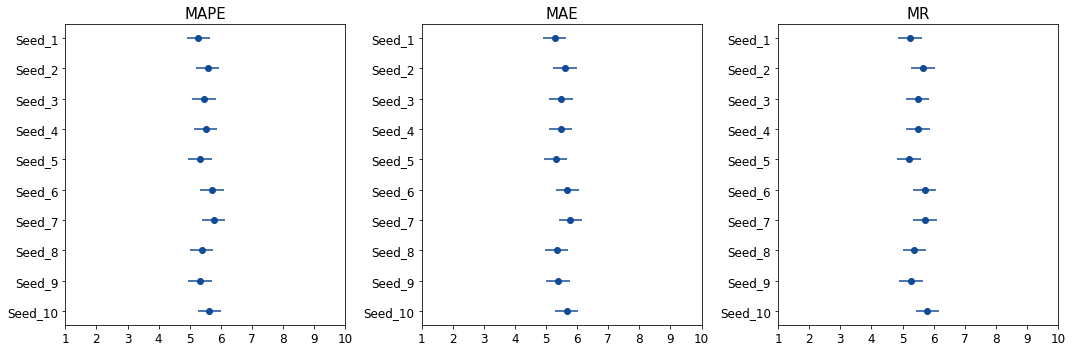

In [11]:
def nemenyi_value(n_models, n_datasets, q):
    return q * (np.sqrt(n_models*(n_models+1) / (6*n_datasets)))

n_models = 10
q_alpha = 3.164

f, axes = plt.subplots(1, 3, figsize=(15, 5))
ax1, ax2, ax3 = axes[0], axes[1], axes[2]
axes_list = [ax1, ax2, ax3]

# MAPE
df = pd.read_excel(current_dir+'/Analysis-CRS/ChangCR/MAPE/MAPE-'+str(split_rs[0])+'.xlsx', header = 0, sheet_name = 0)
for rs in split_rs[1:]:
    df_new = pd.read_excel(current_dir+'/Analysis-CRS/ChangCR/MAPE/MAPE-'+str(rs)+'.xlsx', header = 0, sheet_name = 0)
    df = pd.concat((df, df_new))
df = df.reset_index(drop=True)
df = df[['MAPE_0', 'MAPE_1', 'MAPE_2', 'MAPE_3', 'MAPE_4', 'MAPE_5' ,'MAPE_6' ,'MAPE_7', 'MAPE_8', 'MAPE_9']]

rank = pd.DataFrame(np.nan, index=list(df.index), columns=df.columns)
for j in range(len(df)):
    rank.iloc[j,:] = scipy.stats.rankdata(df.iloc[j,:], method='average')
pvalue = scipy.stats.friedmanchisquare(df['MAPE_0'], df['MAPE_1'], df['MAPE_2'], df['MAPE_3'], df['MAPE_4'], df['MAPE_5'], df['MAPE_6'], df['MAPE_7'], df['MAPE_8'], df['MAPE_9']).pvalue

if pvalue <= 0.05:
    print(pvalue, 'MAPE Passed')
else:
    print(pvalue, 'MAPE Failed')

CD = nemenyi_value(n_models, len(rank), q_alpha)
rank_mean = list(rank.mean())
interval_min = [x for x in rank_mean-CD/2]
interval_max = [x for x in rank_mean+CD/2]

rank.columns = ['Seed_1', 'Seed_2', 'Seed_3', 'Seed_4', 'Seed_5', 'Seed_6', 'Seed_7', 'Seed_8', 'Seed_9', 'Seed_10']
ax1.scatter(rank_mean, rank.columns, color='#114A97')
ax1.hlines(rank.columns, interval_min, interval_max, color='#114A97')
ax1.set_xlim(1, 10)
ax1.set_xticks(np.linspace(1,10,10))
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.tick_params(axis='both', which='major', labelsize=12)

# MAE
df = pd.read_excel(current_dir+'/Analysis-CRS/ChangCR/MAE/MAE-'+str(split_rs[0])+'.xlsx', header = 0, sheet_name = 0)
for rs in split_rs[1:]:
    df_new = pd.read_excel(current_dir+'/Analysis-CRS/ChangCR/MAE/MAE-'+str(rs)+'.xlsx', header = 0, sheet_name = 0)
    df = pd.concat((df, df_new))
df = df.reset_index(drop=True)
df = df[['MAE_0', 'MAE_1', 'MAE_2', 'MAE_3', 'MAE_4', 'MAE_5' ,'MAE_6' ,'MAE_7', 'MAE_8', 'MAE_9']]

rank = pd.DataFrame(np.nan, index=list(df.index), columns=df.columns)
for j in range(len(df)):
    rank.iloc[j,:] = scipy.stats.rankdata(df.iloc[j,:], method='average')
pvalue = scipy.stats.friedmanchisquare(df['MAE_0'], df['MAE_1'], df['MAE_2'], df['MAE_3'], df['MAE_4'], df['MAE_5'], df['MAE_6'], df['MAE_7'], df['MAE_8'], df['MAE_9']).pvalue

if pvalue <= 0.05:
    print(pvalue, 'MAE Passed')
else:
    print(pvalue, 'MAE Failed')

CD = nemenyi_value(n_models, len(rank), q_alpha)
rank_mean = list(rank.mean())
interval_min = [x for x in rank_mean-CD/2]
interval_max = [x for x in rank_mean+CD/2]

rank.columns = ['Seed_1', 'Seed_2', 'Seed_3', 'Seed_4', 'Seed_5', 'Seed_6', 'Seed_7', 'Seed_8', 'Seed_9', 'Seed_10']   
ax2.scatter(rank_mean, rank.columns, color='#114A97')
ax2.hlines(rank.columns, interval_min, interval_max, color='#114A97')
ax2.set_xlim(1, 10)
ax2.set_xticks(np.linspace(1,10,10))
ax2.set_ylim(ax2.get_ylim()[::-1])
ax2.tick_params(axis='both', which='major', labelsize=12)

# MR
df = pd.read_excel(current_dir+'/Analysis-CRS/ChangCR/MR/MR-'+str(split_rs[0])+'.xlsx', header = 0, sheet_name = 0)
for rs in split_rs[1:]:
    df_new = pd.read_excel(current_dir+'/Analysis-CRS/ChangCR/MR/MR-'+str(rs)+'.xlsx', header = 0, sheet_name = 0)
    df = pd.concat((df, df_new))
df = df.reset_index(drop=True)
df = df[['MR_0', 'MR_1', 'MR_2', 'MR_3', 'MR_4', 'MR_5' ,'MR_6' ,'MR_7', 'MR_8', 'MR_9']]

rank = pd.DataFrame(np.nan, index=list(df.index), columns=df.columns)
for j in range(len(df)):
    rank.iloc[j,:] = scipy.stats.rankdata(df.iloc[j,:], method='average')
pvalue = scipy.stats.friedmanchisquare(df['MR_0'], df['MR_1'], df['MR_2'], df['MR_3'], df['MR_4'], df['MR_5'], df['MR_6'], df['MR_7'], df['MR_8'], df['MR_9']).pvalue

if pvalue <= 0.05:
    print(pvalue, 'MR Passed')
else:
    print(pvalue, 'MR Failed')

CD = nemenyi_value(n_models, len(rank), q_alpha)
rank_mean = list(rank.mean())
interval_min = [x for x in rank_mean-CD/2]
interval_max = [x for x in rank_mean+CD/2]

rank.columns = ['Seed_1', 'Seed_2', 'Seed_3', 'Seed_4', 'Seed_5', 'Seed_6', 'Seed_7', 'Seed_8', 'Seed_9', 'Seed_10']
ax3.scatter(rank_mean, rank.columns, color='#114A97')
ax3.hlines(rank.columns, interval_min, interval_max, color='#114A97')
ax3.set_xlim(1, 10)
ax3.set_xticks(np.linspace(1,10,10))
ax3.set_ylim(ax3.get_ylim()[::-1])
ax3.tick_params(axis='both', which='major', labelsize=12)
ax1.set_title('MAPE', size=15)
ax2.set_title('MAE', size=15)
ax3.set_title('MR', size=15)

plt.tight_layout()
plt.savefig(current_dir+'/Figures/Nemenyi-CRS.png')